In [1]:
import random
import numpy as np
import Parsing_midi as pm
import Init_chromo as init
import mido
from mido import Message, MidiFile, MidiTrack
from collections import Counter
import copy
import matplotlib.pyplot as plt
from itertools import combinations # product: 排列

In [2]:
"""
## import function

- Parsing_midi
    - get_midi
    - get_pitch
    - parse_midi
    - separate_phrase

- Init_chromo
    - shift_note
    - merge_duplicate_note
    - extend_duration
"""
print()

### Output to midi file

In [3]:
def to_midi_file(inputfile, program, outputfile):
    ## initialize
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    ## add message
    track.append(Message('program_change', program=program, time=0))
    for i in range(len(inputfile)):
        track.append(Message('note_on', note=inputfile[i].note, velocity=inputfile[i].velocity, time=inputfile[i].time))
    mid.save(outputfile)
    return True

### Seperate phrase
- one bar = 1920 (4 beats)
- sliding window = 7680 (4 bar)
- Parameters:
    - base
    - midi list
    - threshold

In [12]:
midi_list = pm.get_midi('MidiSample/sky.mid',0)

In [17]:
## get midi message
pitch_ary = [[0,1,0], [0,-1,2], [0,1,4], [-1,0,11], [1,0,1], [-1,0,3],[1,0,5]]

pitch_ary = np.array(pitch_ary)

# def pitch_trans(seq):
#     pitch_list = ['C','D','E','F','G','A','B']
#     return pitch_list[seq]

# def get_key(CE, pitch_ary):
#     key = []
#     for i in range(len(pitch_ary)):
#         key.append(abs(pitch_ary[i][0]-int(CE[0])) + abs(pitch_ary[i][1]-int(CE[1])) + \
#                   abs(pitch_ary[i][2]-int(CE[2])))
#     predict_key = pitch_trans(key.index(min(key)))
#     return predict_key

def trans_note_list(song):
    return [song[i].note for i in range(len(song))]

note_msg, midi_msg = pm.separate_song(midi_list, 15360)
parent = midi_msg[2]  # change here for testing

In [18]:
## transform to C major
# for i in range(len(parent)):
#     parent[i].note = parent[i].note -3 # shift
[parent[i].note -3 for i in range(len(parent))]
    
to_midi_file(parent, 1 , 'test.mid')

True

### Evolutionary algorithmn
- selection
- crossover
- mutation
- fitness

In [14]:
## Selection
"""
Parameter:
pop_list
candidate
"""
def select_best(pop_list, chord):
    pop_idx = [i for i in range(len(pop_list))]
    
    candidate = list(combinations(pop_idx, 2))
    scr = []; mid = []
    for i in range(len(candidate)):
        individual1, individual2 = pop_list[candidate[i][0]], pop_list[candidate[i][1]]
        note1 = trans_note_list(individual1)
        note2 = trans_note_list(individual2)
        _score1, _midi1 = fitness(individual1, note1, chord)
        _score2, _midi2 = fitness(individual2, note2, chord)
        scr.append(_score1 + _score2)
        mid.append([_midi1,_midi2])
    scr_ary = np.array(scr)
    top2 = int(scr_ary.argsort()[-1:])
    return mid[top2][0], mid[top2][1], scr[top2]  # 回傳分數最高的一組(2個)candidate


## Crossover
"""
Parameter:
crossover_rate
crossover_point
"""
def crossover(parent, pop):
    crossover_point = random.randint(0,len(parent))
    while crossover_point % 2 != 0 :
        crossover_point = random.randint(0,len(parent))
    pop_midi1 = parent[ :crossover_point] + pop[crossover_point: ]
    pop_midi2 = pop[ :crossover_point] + parent[crossover_point: ]
    return pop_midi1, pop_midi2
 
    
## Mutation
"""
Parameter:
mute_rate
mute_point
mutate_list
"""
def mutation(child):  
    mute_point = random.randint(0,len(child)-1)  #選擇一點做突變
    while mute_point % 2 != 0:
        mute_point = random.randint(0,len(child)-1)
    mutate_note = np.random.choice(8, 1, replace=False, p=[0, 0, 0.3, 0, 0.35, 0, 0, 0.35]) #### TODO!!
    if child[mute_point].note < 80:
        child[mute_point].note = child[mute_point].note + int(mutate_note)
        child[mute_point + 1].note = child[mute_point].note
    else:
        child[mute_point].note = child[mute_point].note - int(mutate_note)
        child[mute_point + 1].note = child[mute_point].note
    return child
   
    
## Evaluation
"""
fitness function
pitch
chord
"""
## base on CE get the chord name 
chord_list = [[0,4,7], [2,5,9], [4,7,11], [5,9,0], [7,11,2], [9,0,4], [11,2,5]]
pitch_list = ['C','D','E','F','G','A','B']

def fitness(midi_msg, note_msg, chord): # type: list
    score = 0
    scale_list = [0,2,4,5,7,9,11]
    
    ## Get first and last note
    first_note = midi_msg[0].note
    last_note = midi_msg[-1].note
    
#     # get chord (by CE) -> get note -> match
#     key = get_key(note_msg, pitch_ary)
#     chord = chord_list[pitch_list.index(key)]
        
    ## Pitch
    for i in range(len(midi_msg) - 2):
        if i % 2 == 0:
            if abs(midi_msg[i].note - midi_msg[i+2].note) == 4: ## major third
                score += 4
            if abs(midi_msg[i].note - midi_msg[i+2].note) == 7: ## perfect fifth
                score += 4
            if abs(midi_msg[i].note - midi_msg[i+2].note) > 7:  ## big jump note
                score = score - 8      
            if midi_msg[i].note % 12 == chord[0]:## chord root note
                score += 6
            if midi_msg[i].note % 12 == chord[1]:## 2nd note
                score += 5
            if midi_msg[i].note % 12 == chord[2]:## 3rd note
                score += 5
            if i == 0 and midi_msg[i].note % 12 == chord[0]:  # first note
                score += 6
            if i == 0 and midi_msg[i].note % 12 == chord[1]:
                score += 4
            if i == 0 and midi_msg[i].note % 12 == chord[2]:
                score += 2
            if i == 0 and midi_msg[i].note % 12 not in chord: # not in chord note
                score -= 3   
            if i == len(midi_msg)-3 and midi_msg[i].note % 12 == chord[0]:  # last note
                score += 6
            if i == len(midi_msg)-3 and midi_msg[i].note % 12 == chord[1]:
                score += 4
            if i == len(midi_msg)-3 and midi_msg[i].note % 12 == chord[2]:
                score += 2
            if i == len(midi_msg)-3 and midi_msg[i].note % 12 not in chord: # not in chord note
                score -= 3
            if midi_msg[i].note % 12 not in chord: # note is not a chord note
                score -= 3
            if midi_msg[i].note % 12 not in scale_list:  # note not in the scale
                score -= 10
            
    return score, midi_msg

### Main Function
- initialize 有六種組合
- 挑分數最高的兩條做crossover, mutation 產生300種不同組合
- 從這300條中挑選分數最高的兩條繼續演化

In [15]:
%%time
## MAIN
MUTATION_RATE = 0.5
CROSSOVER_RATE = 0.7
GENERATIONS = 100
count = 0; score_list = []; midi_list = []

score_list = []; temp = []

chord = [9,0,4]

## Initialize 

# 增加裝飾音
pop1 = init.add_note(parent, -3, 119)   
pop2 = init.add_note(parent, -3, 239)
pop3 = init.add_note(parent, -2, 119)
pop4 = init.add_note(parent, -2, 239)
pop5 = init.add_note(parent, -7, 119)  
pop6 = init.add_note(parent, -7, 239)
pop7 = init.add_note(parent, 4, 119)
pop8 = init.add_note(parent, 4, 239)
pop9 = init.add_note(parent, 2, 119)
pop10 = init.add_note(parent, 2, 239)
pop11 = init.add_note(parent, 7, 119) 
pop12 = init.add_note(parent, 7, 239) 
pop13 = parent                                 # origin       
pop14 = init.merge_duplicate_note(parent)      # 重複的切分音直接轉為連音
pop15 = init.change_duration(parent, 120, 480, 3) # 延長音 16分音符->一拍
pop16 = init.change_duration(parent, 240, 120, 3) # 縮短音 16分音符->8分音符
pop17 = init.remove_note(parent, 300) ## 移除音符
pop17 = init.remove_note(parent, 300) ## 移除音符

pop_list = [pop1, pop2, pop3, pop4, pop5, pop6, pop7, pop8, pop9, pop10, pop11, pop12, pop13, pop14, pop15, pop16, pop17]

# choose 2 best candidate
parent, pop, scr1 = select_best(pop_list, chord)
score_list.append(scr1)


while count < GENERATIONS:
    candidate_list = []
  
    # crossover, mutation * N
    for i in range(50):  
        # crossover
        crossover_rate = round(random.uniform(0, 1),1)
        if crossover_rate < CROSSOVER_RATE:
            crossover_c1, crossover_c2 = crossover(parent, pop)
        else:
            crossover_c1 = parent 
            crossover_c2 = pop
            
        # mutation
        mute_rate = round(random.uniform(0, 1),1)    
        if mute_rate < MUTATION_RATE:    
            mutation_c1 = mutation(crossover_c1)
            mutation_c2 = mutation(crossover_c2)
        else:
            mutation_c1 = crossover_c1
            mutation_c2 = crossover_c2
        
        candidate_list.append(mutation_c1)
        candidate_list.append(mutation_c2)
        
    # select best from 300 populations   
    parent, pop, scr2 = select_best(candidate_list, chord)
    
    if scr2 >= 0:
        to_midi_file(parent, 1 , 'Output_midi/sky_output2_' + str(scr2) + '.mid')
        print("sky_output_" + str(scr2) + "_saved")
    else: 
        to_midi_file(parent, 1 , 'Output_midi/sky_output2_minus_' + str(abs(scr2)) + '.mid')
        print("sky_output_" + str(scr2) + "_saved")
        
    score_list.append(scr2)
        
    count += 1
    print(scr2)
    
print("Finish")

sky_output_-200_saved
-200
sky_output_-492_saved
-492
sky_output_-496_saved
-496
sky_output_-642_saved
-642
sky_output_-558_saved
-558
sky_output_-660_saved
-660
sky_output_-634_saved
-634
sky_output_-518_saved
-518
sky_output_-628_saved
-628
sky_output_-656_saved
-656


KeyboardInterrupt: 

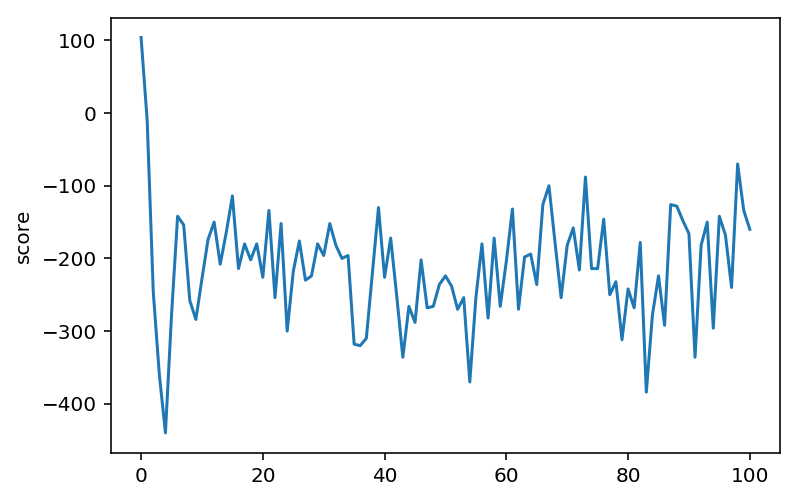

In [14]:
plt.plot(score_list)
plt.ylabel('score')
plt.show()